In [5]:
import matplotlib
import matplotlib.pyplot as plt

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
import numpy as np
import os

import tensorflow as tf

In [3]:
#RNN without using tf rnn cells, to understand the way those ops are structured
#five recurrent neurons, 2 time steps, tanh activation
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

Wx = tf.Variable(tf.random_normal(shape=[n_inputs, n_neurons], dtype=tf.float32))
Wy = tf.Variable(tf.random_normal(shape=[n_neurons, n_neurons], dtype=tf.float32))
b = tf.Variable(tf.zeros([1, n_neurons], dtype=tf.float32))

Y0 = tf.tanh(tf.matmul(X0, Wx) + b)
Y1 = tf.tanh(tf.matmul(Y0, Wy) + tf.matmul(X1, Wx) + b)

init = tf.global_variables_initializer()


In [4]:
#looks similar to feed forward network but the same weights and bias terms are shared by both layers
#and it is feed inputs at each layer and gets outputs at each layer

#feed inputs at both time steps

X0_batch = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]) # t = 0
X1_batch = np.array([[9, 8, 7], [0, 0, 0], [6, 5, 4], [3, 2, 1]]) # t = 1 

#mini batch contains four instances a piece


In [5]:
with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [10]:
#at the end Y0 and Y1 have the network outputs at both time steps for all neurons and instances in each mini batch
#each line corresponds to an instance
print(Y0_val)
print(Y1_val)

[[-0.0664006   0.9625767   0.68105793  0.7091854  -0.898216  ]
 [ 0.9977755  -0.719789   -0.9965761   0.9673924  -0.9998972 ]
 [ 0.99999774 -0.99898803 -0.9999989   0.9967762  -0.9999999 ]
 [ 1.         -1.         -1.         -0.99818915  0.9995087 ]]
[[ 1.         -1.         -1.          0.4020025  -0.9999998 ]
 [-0.12210419  0.62805265  0.9671843  -0.9937122  -0.2583937 ]
 [ 0.9999983  -0.9999994  -0.9999975  -0.85943305 -0.9999881 ]
 [ 0.99928284 -0.99999815 -0.9999058   0.9857963  -0.92205757]]


In [11]:
#implement using static_rnn()
reset_graph()

n_inputs = 3
n_neurons = 5

X0 = tf.placeholder(tf.float32, [None, n_inputs])
X1 = tf.placeholder(tf.float32, [None, n_inputs])

#BasicRNNCell structure for creating each cell as unrolled through time (cell factory)
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
#call static rnn, giving it the cell structure (factory), the inputs, calls the cell once per input, creating two copies,
#five neurons each. with shared weights and biases, chained together. returns two objects: outputs tensors for each time step, 
#tensor with final state (last output)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, [X0, X1], dtype=tf.float32)

Y0, Y1 = output_seqs

init = tf.global_variables_initializer()

In [12]:
with tf.Session() as sess:
    init.run()
    Y0_val, Y1_val = sess.run([Y0, Y1], feed_dict={X0: X0_batch, X1: X1_batch})

In [13]:
Y0_val

array([[ 0.30741334, -0.32884315, -0.6542847 , -0.9385059 ,  0.52089024],
       [ 0.99122757, -0.9542541 , -0.7518079 , -0.9995208 ,  0.9820235 ],
       [ 0.9999268 , -0.99783254, -0.8247353 , -0.9999963 ,  0.99947774],
       [ 0.996771  , -0.68750614,  0.8419969 ,  0.9303911 ,  0.8120684 ]],
      dtype=float32)

In [14]:
Y1_val

array([[ 0.99998885, -0.99976057, -0.0667929 , -0.9999803 ,  0.99982214],
       [-0.6524943 , -0.51520866, -0.37968948, -0.5922594 , -0.08968379],
       [ 0.99862397, -0.99715203, -0.03308626, -0.9991566 ,  0.9932902 ],
       [ 0.99681675, -0.9598194 ,  0.39660627, -0.8307606 ,  0.79671973]],
      dtype=float32)

In [26]:
#packing sequences
#instead of building a ton of placeholders, now there is only one for input where the first dimension is minibatch size
#extracts list of of input sequences for each time step. X_seqs is a list of n_steps tensors of shape[None, n_inputs], 
#first dimension is minibatch size
reset_graph()

n_steps=2

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
X_seqs = tf.unstack(tf.transpose(X, perm=[1, 0, 2]))

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
output_seqs, states = tf.contrib.rnn.static_rnn(basic_cell, X_seqs, dtype=tf.float32)

outputs = tf.transpose(tf.stack(output_seqs), perm=[1, 0, 2])

init = tf.global_variables_initializer()


In [27]:
X_batch = np.array([
        # t = 0      t = 1 
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4
    ])

In [28]:
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [29]:
print(outputs_val)

[[[-0.45652324 -0.68064123  0.40938237  0.63104504 -0.45732826]
  [-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]]

 [[-0.8001535  -0.9921827   0.7817797   0.9971032  -0.9964609 ]
  [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]]

 [[-0.93605185 -0.9998379   0.9308867   0.9999815  -0.99998295]
  [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]]

 [[ 0.9927369  -0.9981933  -0.55543643  0.9989031  -0.9953323 ]
  [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]]


In [30]:
print(np.transpose(outputs_val, axes=[1, 0, 2])[1])
file_writer= tf.summary.FileWriter("tf_logs/RNN_static", tf.get_default_graph())

[[-0.9428799  -0.9998869   0.94055814  0.9999985  -0.9999997 ]
 [-0.637116    0.11300927  0.5798437   0.4310559  -0.6371699 ]
 [-0.9165386  -0.9945604   0.896054    0.99987197 -0.9999751 ]
 [-0.02746338 -0.73191994  0.7827872   0.9525682  -0.9781773 ]]


In [31]:
#using static RNNS still builds a graph with one cell per time step. With lots of time steps, this can get cluttered and
#memory intensive. The solution is using dynamic RNNs
#dynami RNN uses a while loop to run over the cell, and you can set swap_memory=True to use CPU memory during backprop 
# to avoid out of memory errors
#accepts a single tensor for input at all time steps, and outputs a single tensor for all tiem steps
reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
init = tf.global_variables_initializer()

In [32]:
with tf.Session() as sess:
    init.run()
    outputs_val = outputs.eval(feed_dict={X: X_batch})

In [33]:
print(outputs_val)

file_writer= tf.summary.FileWriter("tf_logs/RNN_Dyn", tf.get_default_graph())

[[[-0.85115266  0.87358344  0.5802911   0.8954789  -0.0557505 ]
  [-0.999996    0.99999577  0.9981815   1.          0.37679607]]

 [[-0.9983293   0.9992038   0.98071456  0.999985    0.25192663]
  [-0.7081804  -0.0772338  -0.85227895  0.5845349  -0.78780943]]

 [[-0.9999827   0.99999535  0.9992863   1.          0.5159072 ]
  [-0.9993956   0.9984095   0.83422637  0.99999976 -0.47325212]]

 [[ 0.87888587  0.07356028  0.97216916  0.9998546  -0.7351168 ]
  [-0.9134514   0.3600957   0.7624866   0.99817705  0.80142   ]]]


In [36]:
#variable input sequence lengths (useful for things like sentences etc)

reset_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)

#using sequence length hyperparameter with placeholder to tell the rnn the input length instance by instance
seq_length=tf.placeholder(tf.int32, [None])
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32, sequence_length=seq_length)

In [51]:
init = tf.global_variables_initializer()
 #pad with zeros when the input is smaller
X_batch = np.array([
    # step 0     step 1
        [[0, 1, 2], [9, 8, 7]], # instance 1
        [[3, 4, 5], [0, 0, 0]], # instance 2 (padded with zero vectors)
        [[6, 7, 8], [6, 5, 4]], # instance 3
        [[9, 0, 1], [3, 2, 1]], # instance 4 
])


seq_length_batch = np.array([2, 1, 2, 2])

In [52]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run(
        [outputs, states], feed_dict={X: X_batch, seq_length: seq_length_batch})

In [53]:
print(outputs_val)

[[[-0.9123188   0.16516446  0.5548655  -0.39159346  0.20846416]
  [-1.          0.956726    0.99831694  0.99970174  0.96518576]]

 [[-0.9998612   0.6702289   0.9723653   0.6631046   0.74457586]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.99999976  0.8967997   0.9986295   0.9647514   0.93662   ]
  [-0.9999526   0.9681953   0.96002865  0.98706263  0.85459226]]

 [[-0.96435434  0.99501586 -0.36150697  0.9983378   0.999497  ]
  [-0.9613586   0.9568762   0.7132288   0.97729224 -0.0958299 ]]]


In [54]:
(states_val)

array([[-1.        ,  0.956726  ,  0.99831694,  0.99970174,  0.96518576],
       [-0.9998612 ,  0.6702289 ,  0.9723653 ,  0.6631046 ,  0.74457586],
       [-0.9999526 ,  0.9681953 ,  0.96002865,  0.98706263,  0.85459226],
       [-0.9613586 ,  0.9568762 ,  0.7132288 ,  0.97729224, -0.0958299 ]],
      dtype=float32)

In [57]:
#training RNNS (sequence classifier)
# train using backpropigation through time, unroll first then backprop
#doing this wiht mnist for example, CNN would actually work better for image classif. task
reset_graph()

n_steps = 28 #mnist is 28 * 28
n_inputs = 28 #treat each image as a sequence of 28 rows with 28 pixels each 
n_neurons = 150 # 150 reccurent neurons
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

with tf.name_scope("RNN_with_FC_Logits"):
    basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
    outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)
    logits = tf.layers.dense(states, n_outputs)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy)
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()

In [55]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")
X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [60]:
n_epochs = 100
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "train acc:", acc_train, "test acc:", acc_test)

0 train acc: 0.93333334 test acc: 0.9311
1 train acc: 0.96666664 test acc: 0.9522
2 train acc: 0.97333336 test acc: 0.9586
3 train acc: 0.96666664 test acc: 0.9607
4 train acc: 0.97333336 test acc: 0.9673
5 train acc: 0.98 test acc: 0.9669
6 train acc: 0.97333336 test acc: 0.9693
7 train acc: 0.96666664 test acc: 0.968
8 train acc: 0.9533333 test acc: 0.9723
9 train acc: 0.97333336 test acc: 0.9683
10 train acc: 0.9866667 test acc: 0.9734
11 train acc: 0.96666664 test acc: 0.969
12 train acc: 0.9866667 test acc: 0.9726
13 train acc: 0.9866667 test acc: 0.9774
14 train acc: 0.98 test acc: 0.9705
15 train acc: 0.9866667 test acc: 0.976
16 train acc: 0.9866667 test acc: 0.9739
17 train acc: 0.9866667 test acc: 0.9709
18 train acc: 0.98 test acc: 0.9736
19 train acc: 0.9866667 test acc: 0.9775
20 train acc: 0.96666664 test acc: 0.9763
21 train acc: 0.9866667 test acc: 0.9792
22 train acc: 0.98 test acc: 0.9774
23 train acc: 0.9866667 test acc: 0.9735
24 train acc: 1.0 test acc: 0.9785
25 t

In [61]:

file_writer= tf.summary.FileWriter("tf_logs/RNN_MNIST", tf.get_default_graph())

In [63]:
#multi layer RNN
reset_graph()

n_layers=3
n_neurons = 100

X= tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

with tf.name_scope("Multi_Layer_RNN"):
    layers =[tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
            for layer in range(n_layers)]
    multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
    outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
    states_concat = tf.concat(axis=1, values=states)
    logits = tf.layers.dense(states_concat, n_outputs)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits = logits)
    loss = tf.reduce_mean(xentropy)
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op= optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct= tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
n_epochs=10
batch_size=150

In [64]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "train acc:", acc_train, "test acc:", acc_test)

0 train acc: 0.9266667 test acc: 0.9456
1 train acc: 0.9866667 test acc: 0.9647
2 train acc: 0.94666666 test acc: 0.9663
3 train acc: 0.98 test acc: 0.9757
4 train acc: 0.98 test acc: 0.9724
5 train acc: 0.9866667 test acc: 0.9785
6 train acc: 0.9866667 test acc: 0.9692
7 train acc: 1.0 test acc: 0.981
8 train acc: 0.99333334 test acc: 0.9788
9 train acc: 0.99333334 test acc: 0.9809


In [12]:
#creating time series data 


t_min, t_max = 0, 30
resolution = 0.1

def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

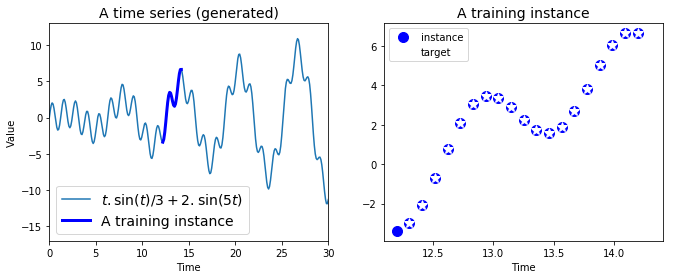

In [13]:
t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()

In [14]:
X_batch, y_batch = next_batch(1, n_steps)
np.c_[X_batch[0], y_batch[0]]

array([[-4.24553919, -5.13924114],
       [-5.13924114, -5.61776824],
       [-5.61776824, -5.57844691],
       [-5.57844691, -5.03687906],
       [-5.03687906, -4.12290627],
       [-4.12290627, -3.04869236],
       [-3.04869236, -2.05674157],
       [-2.05674157, -1.36058129],
       [-1.36058129, -1.09263318],
       [-1.09263318, -1.27203555],
       [-1.27203555, -1.8002942 ],
       [-1.8002942 , -2.48582433],
       [-2.48582433, -3.09137187],
       [-3.09137187, -3.39269965],
       [-3.39269965, -3.23416503],
       [-3.23416503, -2.56757565],
       [-2.56757565, -1.46480336],
       [-1.46480336, -0.1010603 ],
       [-0.1010603 ,  1.28707652],
       [ 1.28707652,  2.45862412]])

In [32]:

reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100
n_outputs = 1

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

#each cell has an output vector of size 100 per time step (matching n_neurons) however, in order to make predictions 
#we want the cell to output a single value at each time step (while still passing the 100 vector to the next cell)
#the simplest way to do this is an output projection wrapper

with tf.name_scope("RNN_OPW"):
    cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu),
                                             output_size=n_outputs)
    outputs, states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)
    
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(outputs - y)) #mse
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

n_iterations = 1500
batch_size = 50

In [33]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE", mse)
            
    saver.save(sess, "./Time_series_model")

0 	MSE 11.967254
100 	MSE 0.525841
200 	MSE 0.1495599
300 	MSE 0.07279411
400 	MSE 0.06158535
500 	MSE 0.05938873
600 	MSE 0.05470166
700 	MSE 0.047849063
800 	MSE 0.05107608
900 	MSE 0.047209196
1000 	MSE 0.047058314
1100 	MSE 0.047831465
1200 	MSE 0.04083041
1300 	MSE 0.047086805
1400 	MSE 0.041784383


In [34]:
#now that we have trained the model, we can make some predictions

with tf.Session() as sess:
    saver.restore(sess, "./Time_series_model")
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})

INFO:tensorflow:Restoring parameters from ./Time_series_model


In [35]:
y_pred

array([[[-3.407753 ],
        [-2.4575484],
        [-1.1029298],
        [ 0.7815629],
        [ 2.2002175],
        [ 3.126768 ],
        [ 3.4037762],
        [ 3.3489153],
        [ 2.8798013],
        [ 2.2659323],
        [ 1.6447463],
        [ 1.5210768],
        [ 1.8972012],
        [ 2.7159088],
        [ 3.8894904],
        [ 5.140914 ],
        [ 6.142068 ],
        [ 6.666671 ],
        [ 6.6410103],
        [ 6.0725527]]], dtype=float32)

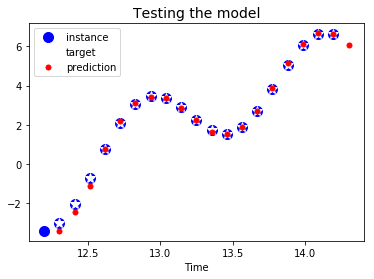

In [36]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")


plt.show()


In [37]:

file_writer= tf.summary.FileWriter("tf_logs/RNN_Time_Series", tf.get_default_graph())

In [38]:
#predictions farther into the future (generative)
with tf.Session() as sess:
    saver.restore(sess, "./Time_series_model")
    sequence = [0.] * n_steps
    for iteration in range(300):
        X_batch = np.array(sequence[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./Time_series_model


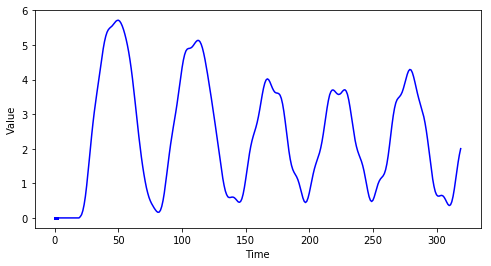

In [39]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(len(sequence)), sequence, "b-")
plt.plot(t[:n_steps], sequence[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()

INFO:tensorflow:Restoring parameters from ./Time_series_model


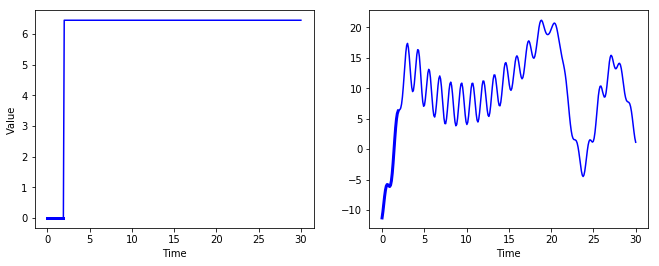

In [40]:
with tf.Session() as sess:
    saver.restore(sess, "./Time_series_model")
    
    sequence1 = [0. for i in range(n_steps)]
    sequence2 = [time_series(i * resolution + t_min + (t_max-t_min/3)) for i in range(n_steps)]
    
    for iteration in range(len(t)- n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence1.append(y_pred[0,-1, 0])
        
    
    for iteration in range(len(t) - n_steps):
        X_batch = np.array(sequence2[-n_steps:]).reshape(1, n_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        sequence2.append(y_pred[0, -1, 0])
        
plt.figure(figsize=(11,4))
plt.subplot(121)
plt.plot(t, sequence1, "b-")
plt.plot(t[:n_steps], sequence1[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.plot(t, sequence2, "b-")
plt.plot(t[:n_steps], sequence2[:n_steps], "b-", linewidth=3)
plt.xlabel("Time")
plt.show()

In [41]:
# no output projection wrapper. you can use 1 FC layer to reshape all 
#the data at once for output. this is a significant speed boost b/ there
#is no longer one being trained/referenced at each time step

reset_graph()

n_steps = 20
n_inputs = 1
n_neurons = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.relu)
rnn_outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

n_outputs = 1
learning_rate = 0.001

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])

loss = tf.reduce_mean(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_iterations = 1500
batch_size=50

In [42]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(batch_size, n_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, "\tMSE", mse)
    X_new = time_series(np.array(t_instance[:-1].reshape(-1, n_steps, n_inputs)))
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    
    saver.save(sess, "./TimeS_No_OPW")

0 	MSE 13.907029
100 	MSE 0.5056698
200 	MSE 0.19735886
300 	MSE 0.101214476
400 	MSE 0.06850145
500 	MSE 0.06291986
600 	MSE 0.055129297
700 	MSE 0.049436502
800 	MSE 0.050434686
900 	MSE 0.0482007
1000 	MSE 0.04809868
1100 	MSE 0.04982501
1200 	MSE 0.041912545
1300 	MSE 0.049292978
1400 	MSE 0.043140374


In [43]:
y_pred

array([[[-3.4332483],
        [-2.4594698],
        [-1.1081185],
        [ 0.6882153],
        [ 2.1105688],
        [ 3.0585155],
        [ 3.5144088],
        [ 3.3531117],
        [ 2.808016 ],
        [ 2.1606152],
        [ 1.662645 ],
        [ 1.5578941],
        [ 1.9173537],
        [ 2.7210245],
        [ 3.8667865],
        [ 5.100083 ],
        [ 6.099999 ],
        [ 6.6480975],
        [ 6.6147423],
        [ 6.022089 ]]], dtype=float32)

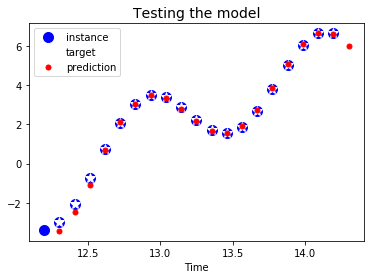

In [44]:
plt.title("Testing the model", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "w*", markersize=10, label="target")
plt.plot(t_instance[1:], y_pred[0,:,0], "r.", markersize=10, label="prediction")
plt.legend(loc="upper left")
plt.xlabel("Time")

plt.show()



In [46]:
#deep rnn; multiRNNCell
reset_graph()
n_inputs = 2
n_steps = 5
n_neurons= 100
n_layers=3

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])

layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
         for layer in range(n_layers)]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
init = tf.global_variables_initializer()
X_batch = np.random.rand(2, n_steps, n_inputs)

In [47]:
with tf.Session() as sess:
    init.run()
    outputs_val, states_val = sess.run([outputs, states], feed_dict={X: X_batch})

In [49]:
outputs_val

array([[[-4.99359481e-02,  5.42742573e-02, -1.02791470e-02,
         -2.38669827e-03,  3.06707546e-02,  5.22854291e-02,
          6.97493088e-03,  7.83798099e-02, -2.42198464e-02,
          3.07376161e-02,  1.40941128e-01,  6.52199015e-02,
          1.63036655e-03,  2.49084141e-02, -1.00140767e-02,
          7.77852461e-02, -1.98126614e-01, -5.80668598e-02,
          4.74586673e-02,  4.54157069e-02, -1.46224827e-01,
          9.55789350e-03, -6.41951784e-02,  8.97417404e-03,
          1.36800796e-01,  6.53845398e-03,  9.78938714e-02,
          4.66969190e-03, -7.40902424e-02,  8.31901357e-02,
         -3.69116403e-02,  1.73824281e-01, -2.70325504e-02,
         -1.87848154e-02, -2.79823616e-02,  9.20242295e-02,
          3.88001055e-02,  5.28086312e-02, -1.89673007e-02,
         -8.93926099e-02,  4.95502390e-02,  9.30288434e-03,
         -1.51676178e-01,  2.59411577e-02, -8.11930280e-03,
         -1.40681481e-02,  1.15221605e-01, -3.55754942e-02,
          2.25580130e-02,  4.75607663e-0

In [57]:
#LSTM cells and GRU Cells - important for finding longer term patterns
reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150
n_outputs = 10
n_layers = 3

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

with tf.name_scope("multi_layer_LSTM_RNN"):
    lstm_cells= [ tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons) for layer in range(n_layers)]
    
    #with peephole (forget and input gates get previous c (long term) state as input, output gate gets current c)
    #lstm_cell = tf.contrib.rnn.LSTMCell(num_units=n_neurons, use_peepholes=True)
    #GRU Cell -> simplified LSTM, quicker but still ~equally effective
    #gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)
    
    multi_cell= tf.contrib.rnn.MultiRNNCell(lstm_cells)
    outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
    top_layer_h_state = states[-1][1]
    logits = tf.layers.dense(top_layer_h_state, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct=tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
n_epochs=10
batch_size=150    
    

In [51]:
states

(LSTMStateTuple(c=<tf.Tensor 'multi_layer_LSTM_RNN/rnn/while/Exit_3:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'multi_layer_LSTM_RNN/rnn/while/Exit_4:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'multi_layer_LSTM_RNN/rnn/while/Exit_5:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'multi_layer_LSTM_RNN/rnn/while/Exit_6:0' shape=(?, 150) dtype=float32>),
 LSTMStateTuple(c=<tf.Tensor 'multi_layer_LSTM_RNN/rnn/while/Exit_7:0' shape=(?, 150) dtype=float32>, h=<tf.Tensor 'multi_layer_LSTM_RNN/rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>))

In [52]:
top_layer_h_state

<tf.Tensor 'multi_layer_LSTM_RNN/rnn/while/Exit_8:0' shape=(?, 150) dtype=float32>

In [58]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape(batch_size, n_steps, n_inputs)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X:X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print("epoch", epoch, "train acc", acc_train, "test acc", acc_test)

epoch 0 train acc 0.94 test acc 0.9579
epoch 1 train acc 0.9866667 test acc 0.9717
epoch 2 train acc 0.98 test acc 0.9777
epoch 3 train acc 0.96666664 test acc 0.9807
epoch 4 train acc 1.0 test acc 0.9807
epoch 5 train acc 1.0 test acc 0.9847
epoch 6 train acc 0.99333334 test acc 0.9864
epoch 7 train acc 0.99333334 test acc 0.9837
epoch 8 train acc 1.0 test acc 0.9887
epoch 9 train acc 1.0 test acc 0.989


In [60]:
file_writer= tf.summary.FileWriter("tf_logs/RNN_LSTM", tf.get_default_graph())

In [61]:
#NLP Applications with RNNs
#word embeddings (turning words to relatively small vectors with a distribution weighted by similar usage)
#import data

from six.moves import urllib

import errno
import os
import zipfile

WORDS_PATH = "datasets/words"
WORDS_URL = 'http://mattmahoney.net/dc/text8.zip'


def fetch_words_data(words_url=WORDS_URL, words_path=WORDS_PATH):
    os.makedirs(words_path, exist_ok=True)
    zip_path = os.path.join(words_path, "words.zip")
    if not os.path.exists(zip_path):
        urllib.request.urlretrieve(words_url, zip_path)
    with zipfile.ZipFile(zip_path) as f:
        data = f.read(f.namelist()[0])
    return data.decode("ascii").split()

In [62]:
words = fetch_words_data()

In [63]:
words[:5]

['anarchism', 'originated', 'as', 'a', 'term']

In [65]:
# build dict
from collections import Counter

vocabulary_size = 50000

vocabulary = [("UNK", None)] + Counter(words).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data= np.array([dictionary.get(word, 0) for word in words])

In [69]:
" ".join(words[:9]), data[:9]


('anarchism originated as a term of abuse first used',
 array([5234, 3081,   12,    6,  195,    2, 3134,   46,   59]))

In [68]:
" ".join([vocabulary[word_index] for word_index in [5241, 3081, 12, 6, 195, 2, 3134, 46, 59]])

'cycles originated as a term of abuse first used'

In [70]:
#generate batch func

import random
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index =(data_index + 1) %len(data)
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [71]:
data_index=0
batch, labels = generate_batch(8, 2, 1)


In [72]:
batch, [vocabulary[word] for word in batch]

(array([3081, 3081,   12,   12,    6,    6,  195,  195], dtype=int32),
 ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])

In [74]:
#Model time
reset_graph()

batch_size = 128
embedding_size= 128 
skip_window=1 #how many words to consider (l & r)
num_skips=2 #times to reuse an input to generate a label

#pick random validation set to smaple nearest neighbors
valid_size = 16 #sample set size
valid_window = 100 # only pick samples in head of distribution
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64 #number of neg examples to sample

learning_rate=0.02

In [80]:
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
vocabulary_size = 50000
embedding_size = 150

init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

#NCE loss
nce_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev= 1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))
loss = tf.reduce_mean(tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed, num_sampled, vocabulary_size))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis = 1, keep_dims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

init = tf.global_variables_initializer()
num_steps = 10001

In [83]:
with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  288.45330810546875
Nearest to people: vinland, dabbled, declared, superstars, participant, collaborations, holstein, usually,
Nearest to can: karsh, fornication, midyear, circumvent, magnetosphere, unarmed, fresco, prion,
Nearest to than: affreightment, leni, bainbridge, electromagnetic, leblanc, reiter, synapomorphies, shaking,
Nearest to its: geer, almonds, midcourse, exoplanets, ernie, apokryphen, mandolins, kassites,
Nearest to their: breakdowns, sami, ligaments, dev, enhancers, micrograms, devouring, disc,
Nearest to have: holographic, rcaf, norway, sipe, fencer, honorary, consubstantiation, milestone,
Nearest to six: countably, ponte, fowl, clerks, waxy, joram, stains, instructions,
Nearest to over: projectiles, urinate, shir, perhaps, warhammer, august, protium, audiobook,
Nearest to two: debbie, avalanche, kabbalistic, secrets, goodbye, dhea, beauharnais, monads,
Nearest to UNK: sail, chemotaxis, meninges, revision, kor, plunging, prosper

In [84]:
np.save("./word_embeddings.npy", final_embeddings)

In [87]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "too many labels"
    plt.figure(figsize=(18,18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy =(x, y),
                     xytext =(5,2),
                     textcoords ='offset points',
                     ha='right',
                     va='bottom')
        

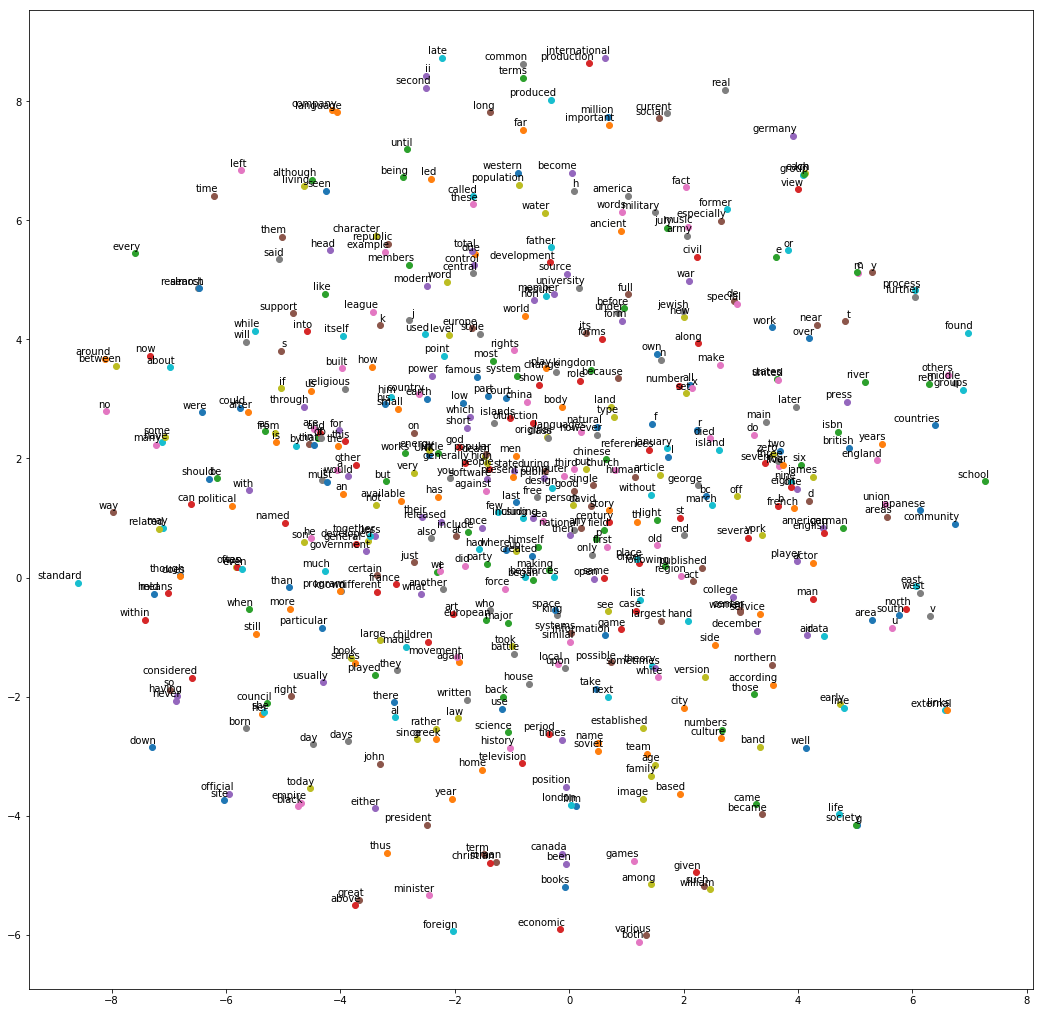

In [88]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)